<a href="https://colab.research.google.com/github/yeesem/Deep_Learning/blob/main/Building_models_for_the_IMDB_Reviews_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePB6P6U/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePB6P6U/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePB6P6U/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [7]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'

# Initilize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size,oov_token = oov_tok)

# Generate the word index dictonary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequence
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen = max_length,truncating = trunc_type)

# Generate and pad the testing examples
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen = max_length)

In [8]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# **Flatten**

In [10]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Defination with a Flatten layer
model_flatten = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim,activation = 'relu'),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
])

# Set the training examples
model_flatten.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
    )

# Print the model summary
model_flatten.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 11526     
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171533 (670.05 KB)
Trainable params: 171533 (670.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(
    padded,
    training_labels_final,
    batch_size = BATCH_SIZE,
    epochs = NUM_EPOCHS,
    validation_data = (testing_padded,testing_labels_final)
)

Epoch 1/10
196/196 [==============================] - 5s 12ms/step - loss: 0.6547 - accuracy: 0.5992 - val_loss: 0.5498 - val_accuracy: 0.8016
Epoch 2/10
196/196 [==============================] - 2s 10ms/step - loss: 0.4676 - accuracy: 0.8525 - val_loss: 0.4607 - val_accuracy: 0.8488
Epoch 3/10
196/196 [==============================] - 2s 10ms/step - loss: 0.3455 - accuracy: 0.9252 - val_loss: 0.4419 - val_accuracy: 0.8420
Epoch 4/10
196/196 [==============================] - 2s 10ms/step - loss: 0.2548 - accuracy: 0.9661 - val_loss: 0.4690 - val_accuracy: 0.8304
Epoch 5/10
196/196 [==============================] - 3s 14ms/step - loss: 0.1994 - accuracy: 0.9826 - val_loss: 0.4855 - val_accuracy: 0.8302
Epoch 6/10
196/196 [==============================] - 3s 15ms/step - loss: 0.1669 - accuracy: 0.9865 - val_loss: 0.5101 - val_accuracy: 0.8272
Epoch 7/10
196/196 [==============================] - 2s 11ms/step - loss: 0.1451 - accuracy: 0.9878 - val_loss: 0.5013 - val_accuracy: 0.8320

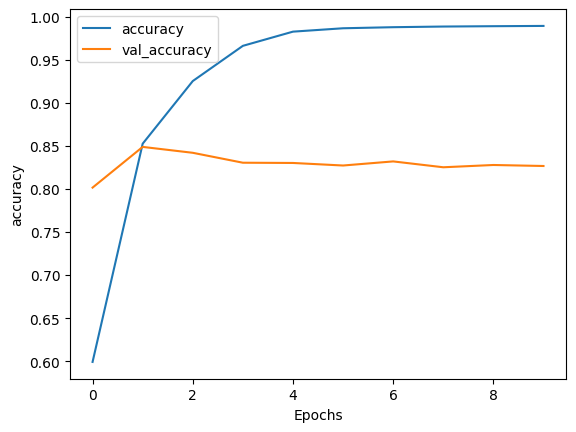

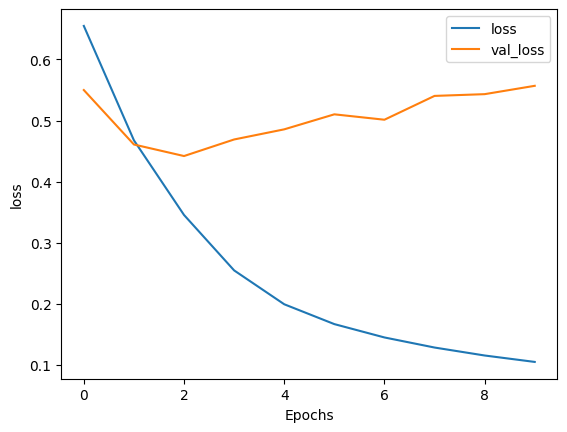

In [13]:
# Plot the accuracy and loss history
plot_graphs(history_flatten,'accuracy')
plot_graphs(history_flatten,'loss')

# **LSTM**

In [14]:
# Parameters
embedding_dims = 16
lstm_dim = 32
dense_dim = 6

# Model Defination with LSTM
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim,activation = 'relu'),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
])

model_lstm.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

# Print the model summary
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirection  (None, 64)                12544     
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172941 (675.55 KB)
Trainable params: 172941 (675.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(
    padded,
    training_labels_final,
    batch_size = BATCH_SIZE,
    epochs = NUM_EPOCHS,
    validation_data = (testing_padded,testing_labels_final)
)

Epoch 1/10
196/196 [==============================] - 58s 252ms/step - loss: 0.5113 - accuracy: 0.7367 - val_loss: 0.3747 - val_accuracy: 0.8348
Epoch 2/10
196/196 [==============================] - 56s 289ms/step - loss: 0.3039 - accuracy: 0.8771 - val_loss: 0.3469 - val_accuracy: 0.8510
Epoch 3/10
196/196 [==============================] - 43s 219ms/step - loss: 0.2381 - accuracy: 0.9085 - val_loss: 0.3599 - val_accuracy: 0.8424
Epoch 4/10
196/196 [==============================] - 38s 195ms/step - loss: 0.2024 - accuracy: 0.9248 - val_loss: 0.4279 - val_accuracy: 0.8312
Epoch 5/10
196/196 [==============================] - 38s 195ms/step - loss: 0.1740 - accuracy: 0.9362 - val_loss: 0.5075 - val_accuracy: 0.8226
Epoch 6/10
196/196 [==============================] - 36s 182ms/step - loss: 0.1372 - accuracy: 0.9533 - val_loss: 0.4719 - val_accuracy: 0.8268
Epoch 7/10
196/196 [==============================] - 39s 198ms/step - loss: 0.1206 - accuracy: 0.9585 - val_loss: 0.5198 - val_ac

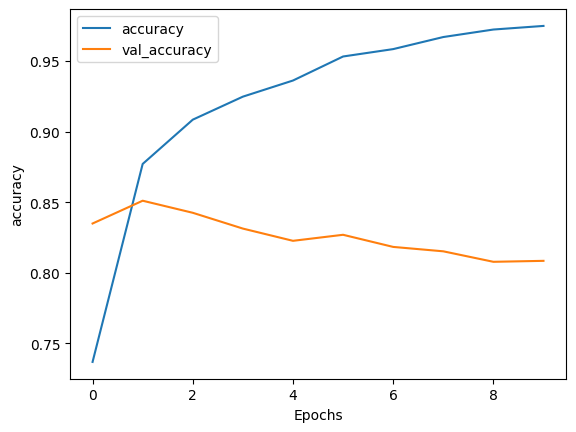

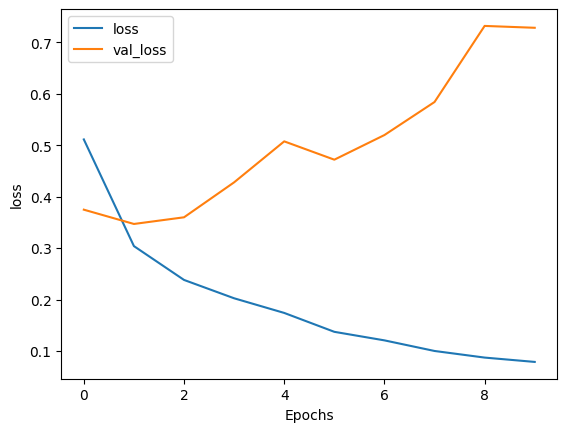

In [17]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

# **GRU**

In [18]:
import tensorflow as tf

# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                9600      
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 6)                 390       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169997 (664.05 KB)
Trainable params: 169997 (664.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 41s 187ms/step - loss: 0.6160 - accuracy: 0.6368 - val_loss: 0.4111 - val_accuracy: 0.8286
Epoch 2/10
196/196 [==============================] - 43s 221ms/step - loss: 0.3377 - accuracy: 0.8575 - val_loss: 0.3417 - val_accuracy: 0.8541
Epoch 3/10
196/196 [==============================] - 38s 195ms/step - loss: 0.2488 - accuracy: 0.9018 - val_loss: 0.3642 - val_accuracy: 0.8456
Epoch 4/10
196/196 [==============================] - 37s 189ms/step - loss: 0.2008 - accuracy: 0.9242 - val_loss: 0.3964 - val_accuracy: 0.8395
Epoch 5/10
196/196 [==============================] - 37s 190ms/step - loss: 0.1666 - accuracy: 0.9398 - val_loss: 0.4270 - val_accuracy: 0.8266
Epoch 6/10
196/196 [==============================] - 38s 196ms/step - loss: 0.1440 - accuracy: 0.9480 - val_loss: 0.4965 - val_accuracy: 0.8301
Epoch 7/10
196/196 [==============================] - 35s 180ms/step - loss: 0.1166 - accuracy: 0.9602 - val_loss: 0.5446 - val_ac

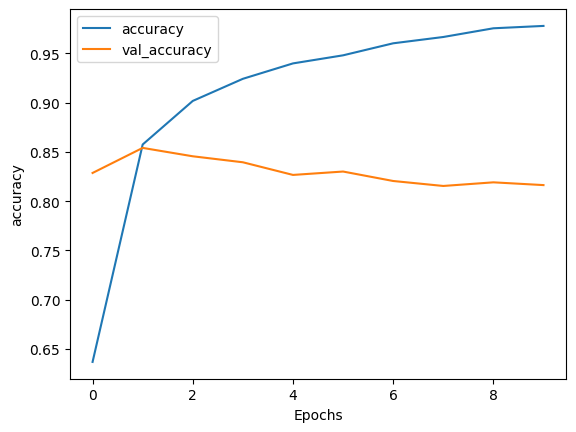

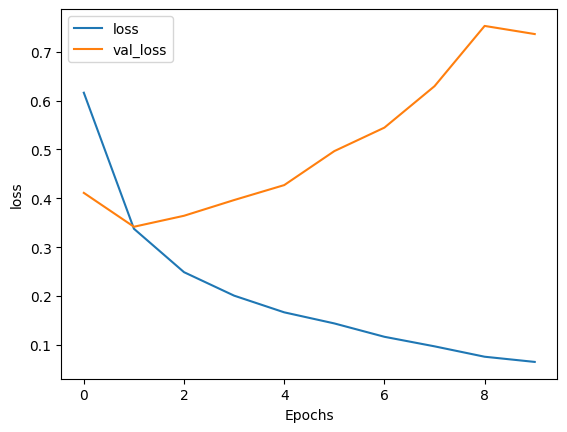

In [20]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

# **Convolutional**

In [21]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_8 (Dense)             (None, 6)                 774       
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171149 (668.55 KB)
Trainable params: 171149 (668.55 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [22]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 12s 52ms/step - loss: 0.5362 - accuracy: 0.7185 - val_loss: 0.3613 - val_accuracy: 0.8429
Epoch 2/10
196/196 [==============================] - 13s 65ms/step - loss: 0.3021 - accuracy: 0.8736 - val_loss: 0.3477 - val_accuracy: 0.8490
Epoch 3/10
196/196 [==============================] - 11s 58ms/step - loss: 0.2420 - accuracy: 0.9049 - val_loss: 0.3681 - val_accuracy: 0.8440
Epoch 4/10
196/196 [==============================] - 11s 58ms/step - loss: 0.2067 - accuracy: 0.9212 - val_loss: 0.4030 - val_accuracy: 0.8367
Epoch 5/10
196/196 [==============================] - 13s 66ms/step - loss: 0.1795 - accuracy: 0.9332 - val_loss: 0.4673 - val_accuracy: 0.8236
Epoch 6/10
196/196 [==============================] - 11s 57ms/step - loss: 0.1595 - accuracy: 0.9421 - val_loss: 0.4917 - val_accuracy: 0.8236
Epoch 7/10
196/196 [==============================] - 13s 65ms/step - loss: 0.1386 - accuracy: 0.9518 - val_loss: 0.5212 - val_accuracy:

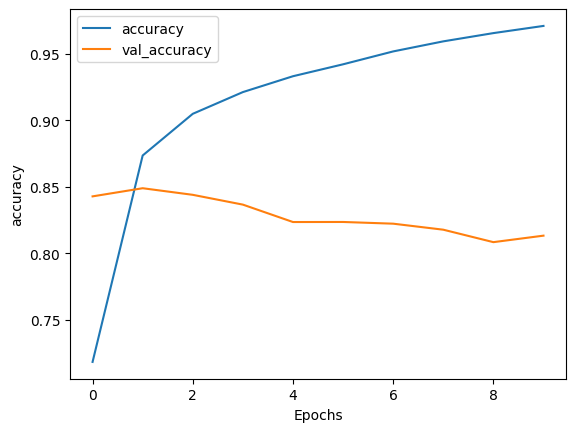

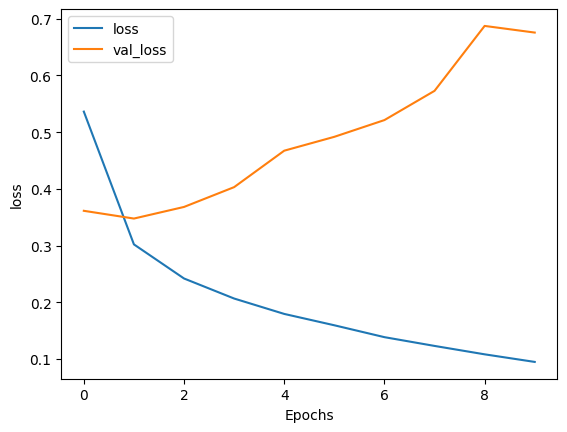

In [23]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')